In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from typing import Dict, List, Optional
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.data as data
import detectron2.data.transforms as T
import detectron2.checkpoint as checkpointer
from detectron2.data import detection_utils as utils
import weakref
import copy
import torch
import time

import imgaug.augmenters as iaa

from astrodet import astrodet as toolkit
from PIL import Image, ImageEnhance
from astropy.visualization import make_lupton_rgb
from astrodet.detectron import plot_stretch_Q
from detectron2.utils.file_io import PathManager
from iopath.common.file_io import file_lock

import logging
logger = logging.getLogger(__name__)
import shutil
import json

In [2]:
# Print the versions to test the imports and so we know what works
print(detectron2.__version__)
print(np.__version__)
print(cv2.__version__)

0.6
1.20.3
4.5.3


In [3]:
# Prettify the plotting
from astrodet.astrodet import set_mpl_style
set_mpl_style()

### First, get some HSC data from training_data.ipynb

In [4]:
dirpath = '/home/shared/hsc/HSC/HSC_DR3/data/' # Path to dataset
output_dir = '/home/shared/hsc/HSC/HSC_DR3/models/'

dataset_names = ['train', 'test', 'val'] 

In [34]:
#this block is for debug purposes, set to -1 to include every sample
sampleNumbers = 2000

In [35]:
from detectron2.structures import BoxMode
from astropy.io import fits
import glob
#Yufeng Jun19 add test here
dataset_names = ['train','test', 'val'] # train
filenames_dict_list = [] # List holding filenames_dict for each dataset

for i, d in enumerate(dataset_names):
    data_path = os.path.join(dirpath, d)

    # Get dataset dict info
    filenames_dict = {}
    filenames_dict['filters'] = ['g', 'r', 'i']

    # Get each unqiue tract-patch in the data directory
    #file = full path name
    files = glob.glob(os.path.join(data_path, '*_scarlet_segmask.fits'))
    if sampleNumbers != -1:
        files = files[:sampleNumbers]
    # s = sample name
    s = [os.path.basename(f).split('_scarlet_segmask.fits')[0] for f in files]
    #print(f'Tract-patch List: {s}')
    for f in filenames_dict['filters']:
        filenames_dict[f] = {}
        # List of image files in the dataset
        #Yufeng dec/21  [Errno 2] No such file or directory: '/home/shared/hsc/test/G-I-8525-4,5-c5_scarlet_img'
        #filenames_dict[f]['img'] = [os.path.join(data_path, f'{f.upper()}-{tract_patch}_scarlet_img.fits') for tract_patch in s]
        #Yufeng jan 18 f.upper() indicates filter, tract_patch[1:] removes the default I band in the front
        filenames_dict[f]['img'] = [os.path.join(data_path, f.upper() + f'{tract_patch[1:]}_scarlet_img.fits') for tract_patch in s]
        # List of mask files in the dataset
        #Yufeng jan 18 all mask files are in the I band
        filenames_dict[f]['mask'] = [os.path.join(data_path, f'{tract_patch}_scarlet_segmask.fits') for tract_patch in s]
        
    filenames_dict_list.append(filenames_dict)

In [36]:
ftrain=glob.glob(os.path.join('/home/shared/hsc/HSC/HSC_DR3/data/train/', '*_scarlet_segmask.fits'))
ftest=glob.glob(os.path.join('/home/shared/hsc/HSC/HSC_DR3/data/test/', '*_scarlet_segmask.fits'))
fval=glob.glob(os.path.join('/home/shared/hsc/HSC/HSC_DR3/data/val/', '*_scarlet_segmask.fits'))
print(len(ftrain),len(ftest),len(fval))

print(len(ftest)/len(ftrain))

11889 2364 2388
0.19883926318445622


In [37]:
#number of total samples
print('# of train sample: ', len(filenames_dict_list[0]['g']['img']))
print('# of test sample: ', len(filenames_dict_list[1]['g']['img']))

# of train sample:  2000
# of test sample:  2000


In [38]:
garbage_data = []
def get_astro_dicts(filename_dict):
    
    """
    This can needs to be customized to your trianing data format
    
    """
        
    dataset_dicts = []
    filters = list(filename_dict.keys())
    #yufeng april5: why only 1st filter
    f = filename_dict['filters'][0] # Pick the 1st filter for now
    
    # Filename loop
    for idx, (filename_img, filename_mask) in enumerate(zip(filename_dict[f]['img'], filename_dict[f]['mask'])):
        record = {}

        # Open FITS image of first filter (each should have same shape)
        with fits.open(filename_img, memmap=False, lazy_load_hdus=False) as hdul:
            height, width = hdul[0].data.shape
            
        # Open each FITS mask image
        with fits.open(filename_mask, memmap=False, lazy_load_hdus=False) as hdul:
            hdul = hdul[1:]
            sources = len(hdul)
            # Normalize data
            data = [hdu.data for hdu in hdul]
            category_ids = [hdu.header["CAT_ID"] for hdu in hdul]
            ellipse_pars = [hdu.header["ELL_PARM"] for hdu in hdul]
            bbox = [list(map(int, hdu.header["BBOX"].split(','))) for hdu in hdul]
            area = [hdu.header["AREA"] for hdu in hdul]

        # Add image metadata to record (should be the same for each filter)
        for f in filename_dict['filters']:
            record[f"filename_{f.upper()}"] = filename_dict[f]['img'][idx]
        # Assign file_name
        record[f"file_name"] = filename_dict[filename_dict['filters'][0]]['img'][idx]
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []

        # Generate segmentation masks from model
        for i in range(sources):
            image = data[i]
            # Why do we need this?
            if len(image.shape) != 2:
                continue
            height_mask, width_mask = image.shape
            # Create mask from threshold
            mask = data[i]
            # Smooth mask
            #mask = cv2.GaussianBlur(mask, (9,9), 2)
            x,y,w,h = bbox[i] # (x0, y0, w, h)

            # https://github.com/facebookresearch/Detectron/issues/100
            contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
                                                        cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []
            for contour in contours:
                # contour = [x1, y1, ..., xn, yn]
                contour = contour.flatten()
                if len(contour) > 4:
                    contour[::2] += (x-w//2)
                    contour[1::2] += (y-h//2)
                    segmentation.append(contour.tolist())
            # No valid countors
            if len(segmentation) == 0:
                continue

            # Add to dict
            obj = {
                "bbox": [x-w//2, y-h//2, w, h],
                "area": w*h,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": segmentation,
                "category_id": category_ids[i],
                "ellipse_pars": ellipse_pars[i]
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
        #img = read_image(record, normalize="lupton", stretch=.8, Q=150, ceil_percentile=99.9995)
        #img0std = np.std(np.trim_zeros(img[:,:,0].flatten()))
        #if img0std > 10:
        #    img1std = np.std(np.trim_zeros(img[:,:,1].flatten()))
        #    if img1std > 10:
        #        img2std = np.std(np.trim_zeros(img[:,:,2].flatten()))
        #        if img2std > 10:
        #            dataset_dicts.append(record)
        #        else:
        #            garbage_data.append(record)
        #    else:
        #        garbage_data.append(record)
        #else:
        #    garbage_data.append(record)
            
    return dataset_dicts

In [21]:
def convert_to_json(dict_list, name, output_file, allow_cached=True):
    """
    Converts dataset into COCO format and saves it to a json file.
    dataset_name must be registered in DatasetCatalog and in detectron2's standard format.

    Args:
        dataset_name:
            reference from the config file to the catalogs
            must be registered in DatasetCatalog and in detectron2's standard format
        output_file: path of json file that will be saved to
        allow_cached: if json file is already present then skip conversion
    """

    # TODO: The dataset or the conversion script *may* change,
    # a checksum would be useful for validating the cached data

    PathManager.mkdirs(os.path.dirname(output_file))
    with file_lock(output_file):
        if PathManager.exists(output_file) and allow_cached:
            logger.warning(
                f"Using previously cached COCO format annotations at '{output_file}'. "
                "You need to clear the cache file if your dataset has been modified."
            )
        else:            

            print(f"Caching COCO format annotations at '{output_file}' ...")
            tmp_file = output_file + ".tmp"
            with PathManager.open(tmp_file, "w") as f:
                json.dump(dict_list, f)
            shutil.move(tmp_file, output_file)

In [40]:
t0 = time.time()
dataset_dicts = {}
for i, d in enumerate(dataset_names):
    print(f'Loading {d}')
    dataset_dicts[d] = get_astro_dicts(filenames_dict_list[i])
    
print('Took ', time.time()-t0, 'seconds for ', sampleNumbers, ' samples')

Loading train
Loading test
Loading val
Took  3311.316450357437 seconds for  2000  samples


In [41]:
#! rm /home/shared/hsc/HSC/HSC_DR3/data/test.json
#! rm /home/shared/hsc/HSC/HSC_DR3/data/test.json.lock

In [ ]:
#convert_to_coco_json('astro_train', os.path.join(dirpath,'train.json'), allow_cached=True)

convert_to_json(dataset_dicts['train'], 'astro_train', os.path.join(dirpath,'train.json'), allow_cached=False)
convert_to_json(dataset_dicts['test'], 'astro_test', os.path.join(dirpath,'test.json'), allow_cached=False)
convert_to_json(dataset_dicts['val'], 'astro_val', os.path.join(dirpath,'val.json'), allow_cached=False)

Caching COCO format annotations at '/home/shared/hsc/HSC/HSC_DR3/data/train.json' ...


In [5]:
def get_data_from_json(file):
    # Opening JSON file
    with open(file, 'r') as f:
        data = json.load(f)
    return data

In [6]:
datadir='/home/shared/hsc/HSC/HSC_DR3/data/'
t0 = time.time()
dataset_dicts = {}
for i, d in enumerate(dataset_names):
    print(f'Loading {d}')
    dataset_dicts[d] = get_data_from_json(datadir+dataset_names[i]+'_full.json')
    
print('Took ', time.time()-t0, 'seconds to load ')

Loading train
Loading test
Loading val
Took  69.81027889251709 seconds to load 


In [7]:
instances_list=[]
for i in range(len(dataset_dicts['train'])):
    instances = len(dataset_dicts['train'][i]['annotations'])
    instances_list.append(instances)
instances_list = np.array(instances_list)

602.0


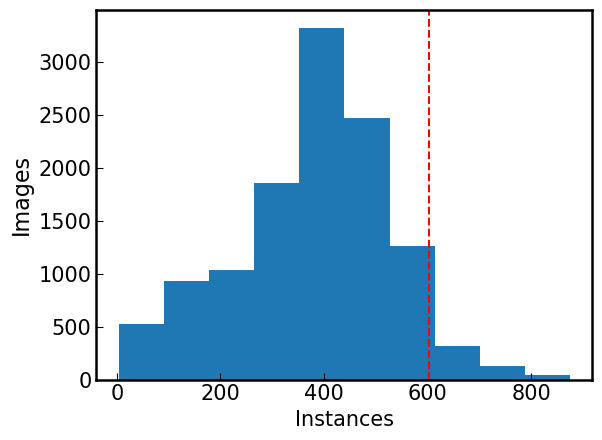

In [23]:
pcen = np.percentile(instances_list,95)
print(pcen)
plt.hist(instances_list)
plt.axvline(pcen,linestyle='--',color='r')
plt.xlabel('Instances',fontsize=15)
plt.ylabel('Images', fontsize=16)
plt.savefig('/home/g4merz/deblend/plots/training_instance_hist.png')
plt.show()

In [12]:
len(dataset_dicts['train'])

11889

In [17]:
new_dataset_dict_train = [ elem for elem in dataset_dicts['train'] if len(elem['annotations'])<= pcen]
print(len(new_dataset_dict_train))
new_dataset_dict_test = [ elem for elem in dataset_dicts['test'] if len(elem['annotations'])<= pcen]
print(len(new_dataset_dict_test))
new_dataset_dict_val = [ elem for elem in dataset_dicts['val'] if len(elem['annotations'])<= pcen]
print(len(new_dataset_dict_val))

11297
2239
2264


In [22]:
convert_to_json(new_dataset_dict_train, 'astro_train', os.path.join(dirpath,'train_95cen.json'), allow_cached=False)
convert_to_json(new_dataset_dict_test, 'astro_test', os.path.join(dirpath,'test_95cen.json'), allow_cached=False)
convert_to_json(new_dataset_dict_val, 'astro_val', os.path.join(dirpath,'val_95cen.json'), allow_cached=False)

Caching COCO format annotations at '/home/shared/hsc/HSC/HSC_DR3/data/train_95cen.json' ...
Caching COCO format annotations at '/home/shared/hsc/HSC/HSC_DR3/data/test_95cen.json' ...
Caching COCO format annotations at '/home/shared/hsc/HSC/HSC_DR3/data/val_95cen.json' ...
